# 1. Variational Quantum Eigensolver

Due to the new updates every few months in this subject, the code has to be run with specific package versions, in order to avoid incompatibility. 

In [1]:
# !pip install matplotlib==3.10.6 pennylane==0.37.0 pyscf==2.10.0 pylatexenc==2.10 ipykernel==6.30.1 qiskit-ibm-runtime==0.43.1 qiskit-aer==0.17.2 qiskit-nature==0.7.2 scikit-learn==1.7.2 qiskit-ibm-catalog==0.11.0 qiskit-serverless==0.27.1 qiskit-optimization pymatgen CoRE_MOF

## 1.1 Theoretical background

We start our VQE project with a simple tast. We wish to determine the lowest eigenvalue of the  matrix U.

$$
U = 
\begin{bmatrix}
1.5 & 0 & 0 & 3.5 \\
0 & 2.5 & -1.5 & 0 \\
0 & -1.5 & 2.5 & 0 \\
3.5 & 0 & 0 & 1.5
\end{bmatrix}
$$

This will be done with VQE-like circuits. To achieve this, we need to express the $U$ as a combination of Pauli operators ${\mathbb{1}, X, Y, Z}$.

$$
\mathbb{1} =
\begin{bmatrix}
1 & 0  \\
0 & 1
\end{bmatrix}\quad
X =
\begin{bmatrix}
0 & 1 \\
1& 0
\end{bmatrix}\quad
Y =
\begin{bmatrix}
0 & -i \\
i & 0
\end{bmatrix}\quad
Z =
\begin{bmatrix}
1 & 0 \\
0 & -1
\end{bmatrix}
$$


This decomposition is required to implement $U$ on a quantum computer. Since we are working with a $4\times4$ matrix, two qubits are needed, so the target decomposition consists of tensor products of two Pauli operators (for example $X_1 \otimes Y_2$, where the subscript specifies the qubit on which the operator acts).


### Decomposition in terms of Pauli operators

Since

$$
X_1\otimes X_2 = 
\begin{bmatrix} 0 & 1\\ 1 & 0 \end{bmatrix} \otimes \begin{bmatrix} 0 & 1\\ 1 & 0 \end{bmatrix} =
\begin{bmatrix} 0 \cdot \begin{bmatrix} 0 & 1\\ 1 & 0 \end{bmatrix} & 1 \cdot \begin{bmatrix} 0 & 1\\ 1 & 0 \end{bmatrix}\\ 1 \cdot \begin{bmatrix} 0 & 1\\ 1 & 0 \end{bmatrix} & 0 \cdot \begin{bmatrix} 0 & 1\\ 1 & 0 \end{bmatrix} \end{bmatrix} = \begin{bmatrix} 0 &  0 & 0 & 1 \\ 0 & 0 & 1 & 0 \\ 0 & 1 & 0 & 0 \\ 1 & 0 & 0 & 0 \end{bmatrix}
$$

$$
Y_1\otimes Y_2 = 
\begin{bmatrix} 0 & -i\\ i & 0 \end{bmatrix} \otimes \begin{bmatrix} 0 & -i\\ i & 0 \end{bmatrix} = \begin{bmatrix} 0 &  0 & 0 & -1 \\ 0 & 0 & 1 & 0 \\ 0 & 1 & 0 & 0 \\ -1 & 0 & 0 & 0 \end{bmatrix}
$$

$$
Z_1\otimes Z_2 = 
\begin{bmatrix} 1 & 0\\ 0 & -1 \end{bmatrix} \otimes \begin{bmatrix} 1 & 0\\ 0 & -1 \end{bmatrix} = \begin{bmatrix} 1 &  0 & 0 & 0 \\ 0 & -1 & 0 & 0 \\ 0 & 0 & -1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix}
$$

$$
\mathbb{1}_{4\times4} = \begin{bmatrix} 1 &  0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix}
$$

We can see that: 

$$
U = \frac{1}{2}\big(4\,I_1\otimes I_2\big) + \frac{1}{2}\big(2\,X_1 \otimes X_2\big) - \frac{1}{2}\big(5\,Y_1\otimes Y_2\big) - \frac{1}{2}\big(Z_1\otimes Z_2\big)
$$

In other words, this gives the required decomposition of the matrix $U$ in terms of Pauli operators. In VQE algorithms, it's practical to work by minimizing the energy of a system, so from this point on the matrix will be referred to as the Hamiltonian $\mathcal{H} = U$ of the system, and the energy as its expectation value on a given state $|\psi(\theta)\rangle$, namely $E(\theta) = \langle \mathcal{H} \rangle_{\theta} = \langle \psi(\theta) | \mathcal{H} | \psi(\theta)\rangle$.

Aditionally, if $|\psi(\theta)\rangle$ is an eigenvector of the $\mathcal{H}$, its energy $E(\theta)$ coincides with the corresponding eigenvalue. The objective is therefore to determine the lowest eigenvalue of $\mathcal{H}$ by minimizing $\langle \mathcal{H} \rangle \rightarrow \langle \mathcal{H} \rangle_{|\psi(\theta_{min})\rangle}$. The challenging aspect is to choose a trial state that admits a good parametrization (there is no guarantee that, by varying $\theta$, the eigenvector associated with the smallest eigenvalue can actually be reached).

### Variational Quantum Eigensolver

The core idea of VQE is to use a quantum computer to evaluate the expectation value of the Hamiltonian on a trial state $|\psi(\theta_1,\theta_2)\rangle$ parameterized by the real parameters $\theta_1$ and $\theta_2$, and then gradually vary these parameters in order to obtain smaller and smaller values of the energy $E(\theta_1,\theta_2)$.

Since $\langle I_1 \otimes I_2 \rangle = 1$ (we ommit now $\otimes$ for readability) :

$$
\langle \mathcal{H} \rangle 
= \frac{1}{2}\big(4\cdot 1 + 2\langle X_1 X_2\rangle - 5\langle Y_1 Y_2\rangle - \langle Z_1 Z_2\rangle\big)
$$  

This implies that suitable quantum circuits must be used to estimate the expected values of the operators $X_1 X_2,\ Y_1 Y_2,\ Z_1 Z_2$, and then these contributions are combined to recover the eigenvalue $E = \langle \mathcal{H} \rangle$.

On current quantum devices, measurements are typically performed in the $Z$ basis (the computational basis), which means that we directly access eigenvectors and eigenvalues of $Z$. To measure different observables, a basis change is required, implemented by adding appropriate gates just before the measurement.

For

With:
$$
X=HZH\quad Y=(HS^\dagger)^\dagger Z(HS^\dagger)
$$
it is possible to measure in the $X$ basis by inserting a Hadamard gate $H$ before the measurement. An analogous procedure holds for $Y$, using the combination of Hadamard and phase gates $HS^\dagger$.

In our setting, however, the goal is to measure two-qubit observables.

#### Observable $Z_1 Z_2$
  
The operator $Z_1 Z_2$ acts as follows: 
$$
Z_1 Z_2|00\rangle = +1 |00\rangle \quad\\
Z_1 Z_2|11\rangle = +1 |11\rangle \quad\\
Z_1 Z_2|01\rangle = -1 |01\rangle \quad\\
Z_1 Z_2|10\rangle = -1 |10\rangle \quad\\
$$
In other words, it checks whether the two qubits are in the same state (both $0$ or both $1$), in which case the eigenvalue is $1$, and if they are different the eigenvalue is $-1$. A similar behaviour can be reproduced using a CNOT gate, since this gate writes on the second qubit the binary sum of the two inputs, $\text{CNOT}|q_1\rangle|q_2\rangle = |q_1\rangle|q_1 \oplus q_2\rangle$.
It is important to note that the numerical outcomes (eigenvalues) coincide, but the final states obtained via the CNOT differ from those produced directly by $Z_1 Z_2$.
Indeed, if
* $q_1 = q_2$ (the two qubits are equal), then $|q_1 \oplus q_2\rangle = |0\rangle$ and measuring the second qubit in the computational ($Z$) basis yields the result $+1$,
* $q_1 \neq q_2$, then $|q_1 \oplus q_2\rangle = |1\rangle$ and a measurement yields $-1$, as required.

> Recall that for a general qubit $|\psi\rangle = \alpha |0\rangle + \beta |1\rangle$, one has $\langle Z \rangle = \langle \psi | Z | \psi \rangle = |\alpha|^2 - |\beta|^2$.

Thus, the observable $Z_1 Z_2$ can be accessed by inserting a CNOT gate and then measuring only the second qubit in the standard $Z$ basis. Measuring whether this qubit is in state $|0\rangle$ or $|1\rangle$ gives a direct bijection with the possible outcomes of $Z_1 Z_2$, namely $+1$ or $-1$, respectively. The corresponding circuit is shown below. From now on, we will use the optimized Qiskit python library, at first only to simulate circuit sampling.

Measurement in the ZZ basis


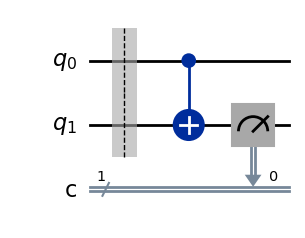

In [32]:
from qiskit import QuantumCircuit, QuantumRegister,  ClassicalRegister, transpile

circuit = QuantumCircuit(2,1)
circuit.barrier()
circuit.cx(0,1)
circuit.measure(1,0) #qubit 1 to cbit 0
print("Measurement in the ZZ basis")
circuit.draw(output="mpl")

Other two-qubit observables can be reduced to a measurement of $Z_1 Z_2$ by applying suitable unitary transformations (i.e., performing an appropriate change of basis).

#### Observable $X_1 X_2$

Using the relation $X = H Z H$ together with the CNOT-based measurement of $Z_1 Z_2$, the observable $X_1 X_2$ can be measured by employing the following circuit:

Measurement in the XX basis


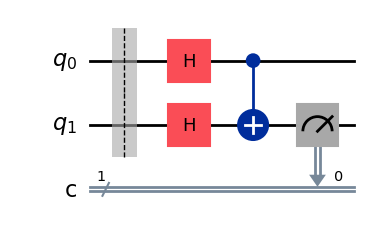

In [33]:
circuit = QuantumCircuit(2,1)
circuit.barrier()
circuit.h(0)
circuit.h(1)
circuit.cx(0,1)
circuit.measure(1,0)
print("Measurement in the XX basis")
circuit.draw(output="mpl")

#### Observable $Y_1 Y_2$

Using the identity $Y = (HS^\dagger)^\dagger Z (HS^\dagger)$ together with the CNOT-based measurement of $Z_1 Z_2$, the observable $Y_1 Y_2$ can be measured by means of the following circuit:

Measurement in the YY basis


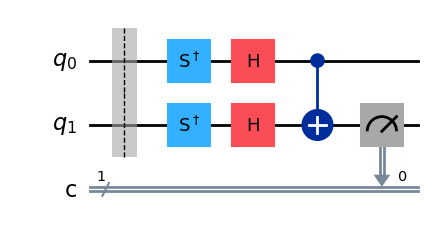

In [34]:
circuit = QuantumCircuit(2,1)
circuit.barrier()
circuit.sdg(0)
circuit.sdg(1)
circuit.h(0)
circuit.h(1)
circuit.cx(0,1)
circuit.measure(1,0)
print("Measurement in the YY basis")
circuit.draw(output="mpl")

## 1.2 VQE Implementation 

The next step is to implement the VQE architecture, which operates as follows:
* select an ansatz for a trial state $|\psi(\theta)\rangle$, parameterized by a real parameter $\theta$
* employ several quantum circuits to estimate the expectation values $\langle X_1 X_2 \rangle_\theta$, $\langle Y_1 Y_2 \rangle_\theta$ and $\langle Z_1 Z_2 \rangle_\theta$ on the same underlying trial state, where the subscript emphasizes the dependence on $\theta$ 
* evaluate the energy $E(\theta) = \langle \mathcal{H} \rangle_\theta$
* update $\theta$ so as to obtain a smaller energy



Following this prescription we chose an ansatz trial circuit. It has to be simple in order to accelerate calculation, but has to include some kind of entanglement. This is achieved by two different Y rotations, and a CNOT gate between the qubits.
$$|\psi(\theta_1, \theta_2)\rangle=
\big[\text{CNOT}_{1,2}\,(R_Y(\theta_1)_1 \otimes R_Y(\theta_2)_2)\big]\,|00\rangle$$




Ansatz initial state, with thetas: 1.3, 0.6


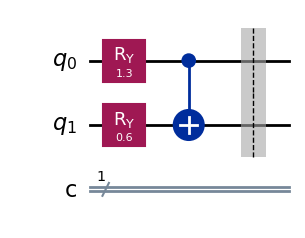

In [35]:
#simple ansatz entangled circuit
circuit = QuantumCircuit(2, 1)

theta0 = 1.3
theta1 = 0.6

#rotations setting the initial state
circuit.ry(theta0, 0)
circuit.ry(theta1, 1)
circuit.cx(0,1)

circuit.barrier()
print(f"Ansatz initial state, with thetas: {theta0}, {theta1}")
circuit.draw(output="mpl")

###### Importation of packages

In [36]:
import qiskit_aer
from scipy.optimize import minimize_scalar, minimize
from numpy import pi

sim_bknd = qiskit_aer.Aer.get_backend('qasm_simulator')

###### Functions declaration

In [37]:
def ansatz(circuit, qr, params):
    #Ansatz uses 2 angles to control qubits independently before entanglement
    #params: list of floats, e.g., [theta_0, theta_1]
    
    theta0 = params[0]
    theta1= params[1]
    # independent rotations
    circuit.ry(theta0, qr[0])
    circuit.ry(theta1, qr[1])
    
    circuit.cx(qr[0], qr[1])
    
    return circuit


def measurements(circuit, qr, cr, op):
    #Applies rotations to measure in XX, YY, or ZZ bases
    
    if op == "XX":
        # with X=HZH
        circuit.h(qr[0])
        circuit.h(qr[1])
        
        # cnot to measure ZZ 
        circuit.cx(qr[0], qr[1])
        circuit.measure(qr[1], cr[0])     
    
    elif op == "YY":
        # with Y = (H S†)Z(H S†)
        circuit.sdg(qr[0])
        circuit.sdg(qr[1])
        circuit.h(qr[0])
        circuit.h(qr[1])
        
        # cnot
        circuit.cx(qr[0], qr[1])
        circuit.measure(qr[1], cr[0])
        
    elif op == "ZZ":
        # cnot
        circuit.cx(qr[0], qr[1])
        circuit.measure(qr[1], cr[0])
    
    else:
        print(f"Measurement in the {op} base is not supported")
        return circuit
        
    return circuit


def hamiltonian(dic):
    #Evaluates the energy of the trial state using the mean values of XX, YY and ZZ.
    #params : Dictionary containing the expectation values of XX, YY and ZZ
    # Apply the Hamiltonian H = 1/2 * (Id + XX - YY - ZZ)
    energy = (4*1 + 2*dic['XX'] - 5*dic['YY']- dic['ZZ'] ) / 2
    return energy


def vqe_step(params, verbose=False):
    # vqe loop with 2 parameters
    times = 10000
    vqe_res = {}   # {'XX': val, 'YY': val, 'ZZ': val}
    circuit_list = {}   # {'XX': qc,  'YY': qc,  'ZZ': qc}

    # we need to run 3 separate circuits: one for XX, one for YY, one for ZZ
    for i in ["XX", "YY", "ZZ"]:
        qr = QuantumRegister(2, "qr")
        cr = ClassicalRegister(1, "cr")
        circuit = QuantumCircuit(qr, cr)

        # Ansatz with current params
        circuit = ansatz(circuit, qr, params)
        circuit.barrier()
        # measurement Gates
        circuit= measurements(circuit, qr, cr, i)
        # Transpile and Run
        circuit_t = transpile(circuit, sim_bknd)
        job = sim_bknd.run(circuit_t, shots=times)
        counts = job.result().get_counts()

        # counts['0'] is the ammount of zeros measured
        # counts['1'] is the ammount of ones
        
        # mean value of Z
        if len(counts) ==1:
            expectation_values = 1 if '0' in counts else -1
        else:
            # 0 in the classical bit means eigenvalue 1
            # 1 in the classical bit means eigenvalue -1
            expectation_values = (counts['0'] - counts['1']) / times      # values for XX YY et ZZ
        vqe_res[i] = expectation_values
        circuit_list[i] = circuit

    # Energy
    energy = hamiltonian(vqe_res)
    
    if verbose:
        print("Mean values from measurement results:\n", vqe_res)
        print()
        print(f"{'Theta 0':>12} {'Theta 1':>12} {'Energy':>12} {'<XX>':>12} {'<YY>':>12} {'<ZZ>':>12}")
        print(f"{params[0]:>12.6f} {params[1]:>12.6f} {energy:>12.6f} "
                f"{vqe_res['XX']:>12.6f} {vqe_res['YY']:>12.6f} {vqe_res['ZZ']:>12.6f}")
        return energy, circuit_list

    return energy

Let us now verify that the whole procedure works correctly.

Mean values from measurement results:
 {'XX': -0.8414, 'YY': -0.6646, 'ZZ': -0.7916}

     Theta 0      Theta 1       Energy         <XX>         <YY>         <ZZ>
   -1.000000     2.500000     3.215900    -0.841400    -0.664600    -0.791600

 Example of the quantum circuit for the measurement of YY


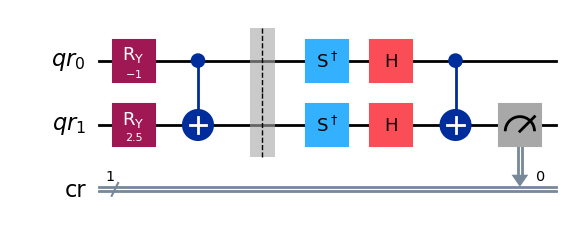

In [38]:
# value of theta
theta = [-1,2.5]
energy, circuit_list = vqe_step(theta, verbose = True)
# Plot for the measurement of YY
op_example = 'YY'
print(f"\n Example of the quantum circuit for the measurement of {op_example}")
circuit_list[op_example].draw(output="mpl")

We see that for the parameters $\theta_0 = -1.0$ and $\theta_1 = 2.5$, the energy $E(\theta_0,\theta_1) = \langle \mathcal{H} \rangle_{\theta_0,\theta_1} \approx 3.243$.

Our aim is to find a value for the parameter that gives the lowest possible energy, and that is the desired lowest eigenvalue.  
The minimization procedure can be done by hand, or by setting up an optimizer. 

##### Using an optimizer

In [39]:
# guess for theta
initial_theta = [0.0, 0.0]

print("Starting VQE Optimization...")
res = minimize(
    vqe_step, 
    initial_theta, method='COBYLA', options={'maxiter': 100})
print(res)

print("\nOptimization Complete!")
print(f"Optimal Angles: {res.x}")
print(f"Minimum Energy: {res.fun:.4f}") 

Starting VQE Optimization...
 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: -1.9965
       x: [-1.519e+00  3.866e-02]
    nfev: 31
   maxcv: 0.0

Optimization Complete!
Optimal Angles: [-1.51871447  0.03865918]
Minimum Energy: -1.9965


##### Conclusion
The optimizer successfully converges to a solution. More precisely, it identifies optimal values around $\theta_0 \approx -1.6$ and $\theta_1 \approx 0.0$, for which the corresponding energy is $E(\theta) \approx -1.998$.
We will now verify this result by passing these values to the vqe_step function.

In [40]:
lowest, circuit_list = vqe_step(res.x, verbose=True)
print(lowest)

Mean values from measurement results:
 {'XX': -0.9984, 'YY': 0.9978, 'ZZ': 0.9994}

     Theta 0      Theta 1       Energy         <XX>         <YY>         <ZZ>
   -1.518714     0.038659    -1.992600    -0.998400     0.997800     0.999400
-1.9926


And we can directly confirm that the target result is obtained as:

$$
\langle \mathcal{H} \rangle_{\theta_1,\theta_2} 
= \frac{1}{2}\big(4 + 2\langle X X\rangle - 5\langle Y Y\rangle - \langle Z Z\rangle \big) \
\approx \frac{1}{2}\big(4 + 2(-1) - 5(1) - (1)\big) = -2
$$  

with $\langle XX \rangle \approx -1$, $\langle YY \rangle \approx 1$, $\langle ZZ \rangle \approx 1$.  

**Therefore, the Task is solved: the lowest eigenvalue of $\mathcal{H}$ (i.e., of $U$) is found to be $-2$.**

###### Final (classical) check
As a final step, the outcome of our calculation can be validated using SciPy’s eigensolver.

In [41]:
import numpy as np
I = np.array([[1,0],[0,1]])
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])

# evaluation of two qubit Pauli matrices
II = np.kron(I, I)
XX = np.kron(X, X)
YY = np.kron(Y, Y)
ZZ = np.kron(Z, Z)
# hamiltonian
H = 0.5 * (4*II + 2*XX - 5*YY - ZZ)
print("Desired Hamiltonian H = \n", H)

Desired Hamiltonian H = 
 [[ 1.5+0.j  0. +0.j  0. +0.j  3.5+0.j]
 [ 0. +0.j  2.5+0.j -1.5+0.j  0. +0.j]
 [ 0. +0.j -1.5+0.j  2.5+0.j  0. +0.j]
 [ 3.5+0.j  0. +0.j  0. +0.j  1.5+0.j]]


This matrix coincides with $U$. We now proceed to compute its eigenvalues.

In [42]:
import scipy

#eigenvalues and eigenvectors of H
eigenvalues, eigenvectors = scipy.linalg.eig(H)
print("Eigenvalues:", eigenvalues)

Eigenvalues: [ 5.+0.j -2.+0.j  4.+0.j  1.+0.j]


$-2$ does appear as the smallest eigenvalue, in agreement with the value obtained using VQE.

In [ ]:
%reset -f   #we reset the jupyter kernel to delete previous variables